In [2]:
import pandas as pd
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
plt.rcParams["font.family"] = "Nimbus Roman"
plt.rcParams["font.size"] = 18  # Adjust the font size
colors = ['#a8ddb5', '#7bccc4', '#43a2ca','#0868ac']

def read_text_files(directory,component,number,label):
    text_data = []
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            with open(os.path.join(directory, filename), 'r') as file:
                d={
                'In-Flight':0,
                'Throughput':0,
                'Latency(ms)': 0,
                'ScaleFactor': component,
                "# of Components":number,
                "Label":label,
                "Total Keys":0,
                "Total Fake Keys":0,
                }
                for line in file:
                    if line.startswith("In-Flight Requests"):
                        inFlight = int(line.split(' ')[2].strip())
                        d['In-Flight']=inFlight
                    if line.startswith("Ops/s"):
                        parts = line.split(',')
                        throughput = int(parts[1])
                        d['Throughput']=throughput/30
                    
                    if line.startswith("Average Latency"):
                        latency = int(line.split(' ')[2])
                        d['Latency(ms)']=latency
                    
                    if line.startswith("Total Key Added"):
                        tKeys = int(line.split(":")[1])
                        d['Total Keys']=tKeys
                    
                    if line.startswith("Total Fake Keys Added"):
                        fKeys = int(line.split(":")[1])
                        d['Total Fake Keys']=fKeys
                
                text_data.append(d)
    return text_data


### Different In-Flight, All <1s av latency

In [7]:

##Waffle

fakeOnZipf0 = "/home/haseeb/Desktop/ReviewGraphs/FakeOverhead/Waffle/Zipf0/Fake"
noFakeZipf0 = "/home/haseeb/Desktop/ReviewGraphs/FakeOverhead/Waffle/Zipf0/NoFake"

fakeOnZipf9 = "/home/haseeb/Desktop/ReviewGraphs/FakeOverhead/Waffle/Zipf9Under1s/Fake"
noFakeZipf9 = "/home/haseeb/Desktop/ReviewGraphs/FakeOverhead/Waffle/Zipf9Under1s/NoFake"

fakeDFZipf0  = pd.DataFrame(read_text_files(fakeOnZipf0 ,"Waffle",3,"Fake-Zipf0"))
nofakeDFZipf0  = pd.DataFrame(read_text_files(noFakeZipf0 ,"Waffle",3,"noFake-Zipf0"))

fakeDFZipf9  = pd.DataFrame(read_text_files(fakeOnZipf9 ,"Waffle",3,"Fake-Zipf0.99"))
nofakeDFZipf9  = pd.DataFrame(read_text_files(noFakeZipf9 ,"Waffle",3,"noFake-Zipf0.99"))


## ORAM

oRAMfakeOnZipf0 = "/home/haseeb/Desktop/ReviewGraphs/FakeOverhead/ORAM/Zipf0/Fake"
oRAMnoFakeZipf0 = "/home/haseeb/Desktop/ReviewGraphs/FakeOverhead/ORAM/Zipf0/NoFake"

oRAMfakeOnZipf9 = "/home/haseeb/Desktop/ReviewGraphs/FakeOverhead/ORAM/Zipf9Under1s/Fake"
oRAMnoFakeZipf9 = "/home/haseeb/Desktop/ReviewGraphs/FakeOverhead/ORAM/Zipf9Under1s/NoFake"

oRAMfakeDFZipf0  = pd.DataFrame(read_text_files(oRAMfakeOnZipf0 ,"ORAM",3,"Fake-Zipf0"))
oRAMnofakeDFZipf0  = pd.DataFrame(read_text_files(oRAMnoFakeZipf0 ,"ORAM",3,"noFake-Zipf0"))

oRAMfakeDFZipf9  = pd.DataFrame(read_text_files(oRAMfakeOnZipf9 ,"ORAM",3,"Fake-Zipf0.99"))
oRAMnofakeDFZipf9  = pd.DataFrame(read_text_files(oRAMnoFakeZipf9 ,"ORAM",3,"noFake-Zipf0.99"))




combined_df = pd.concat([fakeDFZipf0,nofakeDFZipf0,fakeDFZipf9,nofakeDFZipf9,oRAMfakeDFZipf0,oRAMnofakeDFZipf0,oRAMfakeDFZipf9,oRAMnofakeDFZipf9])

combined_df['PercentFake'] = combined_df['Total Fake Keys'] / combined_df['Total Keys'] * 100
combined_df['PercentFake'] = combined_df['PercentFake'].fillna(0)

grouped_df = combined_df.groupby(['ScaleFactor', 'Label']).agg({
    'Throughput': 'mean',
    'Latency(ms)': 'mean',
    'PercentFake': 'mean'
}).reset_index()

grouped_df[grouped_df['ScaleFactor'] == "Waffle"]


,ScaleFactor,Label,Throughput,Latency(ms),PercentFake
4,Waffle,Fake-Zipf0,2897.922222,942.000000,0.993802
5,Waffle,Fake-Zipf0.99,1002.822222,882.333333,2.946576
6,Waffle,noFake-Zipf0,3007.322222,911.666667,0.000000
7,Waffle,noFake-Zipf0.99,216.611111,711.333333,0.000000


In [5]:
onlyWaffle = combined_df[combined_df['ScaleFactor']=="Waffle"]

onlyWaffle['Skew'] = onlyWaffle['Label'].apply(lambda label: '0.99' if 'Zipf0.99' in label else '0')
onlyWaffle


/tmp/ipykernel_2777914/4146957924.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onlyWaffle['Skew'] = onlyWaffle['Label'].apply(lambda label: '0.99' if 'Zipf0.99' in label else '0')


,In-Flight,Throughput,Latency(ms),ScaleFactor,# of Components,Label,Total Keys,Total Fake Keys,PercentFake,Skew
0,2800,2888.000000,943,Waffle,3,Fake-Zipf0,2038468,11076,0.543349,0
1,2800,2969.400000,922,Waffle,3,Fake-Zipf0,2040555,28935,1.417997,0
2,2800,2836.366667,961,Waffle,3,Fake-Zipf0,1995176,20352,1.020060,0
0,2800,2974.800000,924,Waffle,3,noFake-Zipf0,0,0,0.000000,0
1,2800,3091.833333,885,Waffle,3,noFake-Zipf0,0,0,0.000000,0
2,2800,2955.333333,926,Waffle,3,noFake-Zipf0,0,0,0.000000,0
0,900,1043.166667,849,Waffle,3,Fake-Zipf0.99,1185082,38634,3.260028,0.99
1,900,1011.566667,875,Waffle,3,Fake-Zipf0.99,1199627,31179,2.599058,0.99
2,900,953.733333,923,Waffle,3,Fake-Zipf0.99,1126468,33576,2.980644,0.99
0,900,236.033333,730,Waffle,3,noFake-Zipf0.99,205020,0,0.000000,0.99


/tmp/ipykernel_2777914/2344359869.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onlyWaffle['FakeType'] = onlyWaffle['PercentFake'].apply(lambda x: 'Fake' if x>0 else 'noFake')


Number of bars: 6, Number of values: 4


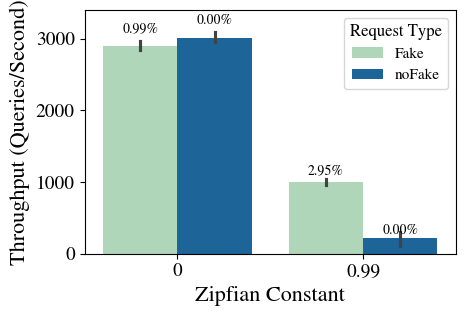

In [6]:
onlyWaffle['FakeType'] = onlyWaffle['PercentFake'].apply(lambda x: 'Fake' if x>0 else 'noFake')

fakePercMeans = [0.993802,2.946576667, 0 , 0]

# Create the plot
fig, ax = plt.subplots(figsize=(5, 3.5))

# Define consistent colors for Fake and noFake
colors = {'Fake': '#a8ddb5', 'noFake': '#0868ac'}  # Blue for Fake, Orange for noFake

# Create the grouped bar plot
sns.barplot(data=onlyWaffle, x="Skew", y="Throughput", hue="FakeType", palette=colors, ax=ax)

# Add the fakePercMeans values on top of each bar
bars = ax.patches
# Since we have 4 values for 4 bars, but grouped bars might create more patches
# Let's check how many bars we actually have and map accordingly
print(f"Number of bars: {len(bars)}, Number of values: {len(fakePercMeans)}")

# If we have exactly 4 bars, use direct mapping
if len(bars) == 4:
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{fakePercMeans[i]:.2f}%', 
                ha='center', va='bottom', fontsize=10)
else:
    # For grouped bars, we need to be more careful about mapping
    # Assuming bars are ordered by group then by hue
    for i, bar in enumerate(bars):
        if i < len(fakePercMeans):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + height*0.05,
                    f'{fakePercMeans[i]:.2f}%', 
                    ha='center', va='bottom', fontsize=10)

# Customize the plot
ax.set_ylabel("Throughput (Queries/Second)", fontsize=16)
ax.set_xlabel("Zipfian Constant", fontsize=16)
ax.set_ylim(0,3400)
# ax.set_title("Fake Request Overhead", fontsize=13)
ax.legend(title="Request Type", loc="upper right", fontsize=11, title_fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.show()

fig.savefig("/home/haseeb/Desktop/ReviewGraphs/Figures/FakeOverhead.png", format='png')

### Same In-Flight

In [29]:

##Waffle

fakeOnZipf0 = "/home/haseeb/Desktop/ReviewGraphs/FakeOverhead/Waffle/Zipf0/Fake"
noFakeZipf0 = "/home/haseeb/Desktop/ReviewGraphs/FakeOverhead/Waffle/Zipf0/NoFake"

fakeOnZipf9 = "/home/haseeb/Desktop/ReviewGraphs/FakeOverhead/Waffle/Zipf9Over1s/Fake"
noFakeZipf9 = "/home/haseeb/Desktop/ReviewGraphs/FakeOverhead/Waffle/Zipf9Over1s/NoFake"

fakeDFZipf0  = pd.DataFrame(read_text_files(fakeOnZipf0 ,"Waffle",3,"Fake-Zipf0"))
nofakeDFZipf0  = pd.DataFrame(read_text_files(noFakeZipf0 ,"Waffle",3,"noFake-Zipf0"))

fakeDFZipf9  = pd.DataFrame(read_text_files(fakeOnZipf9 ,"Waffle",3,"Fake-Zipf0.99"))
nofakeDFZipf9  = pd.DataFrame(read_text_files(noFakeZipf9 ,"Waffle",3,"noFake-Zipf0.99"))






combined_df = pd.concat([fakeDFZipf0,nofakeDFZipf0,fakeDFZipf9,nofakeDFZipf9])

combined_df['PercentFake'] = combined_df['Total Fake Keys'] / combined_df['Total Keys'] * 100
combined_df['PercentFake'] = combined_df['PercentFake'].fillna(0)

grouped_df = combined_df.groupby(['ScaleFactor', 'Label']).agg({
    'Throughput': 'mean',
    'Latency(ms)': 'mean',
    'PercentFake': 'mean'
}).reset_index()

grouped_df


,ScaleFactor,Label,Throughput,Latency(ms),PercentFake
0,Waffle,Fake-Zipf0,2897.922222,942.000000,0.993802
1,Waffle,Fake-Zipf0.99,1283.766667,2047.333333,1.445550
2,Waffle,noFake-Zipf0,3007.322222,911.666667,0.000000
3,Waffle,noFake-Zipf0.99,276.855556,1591.333333,0.000000


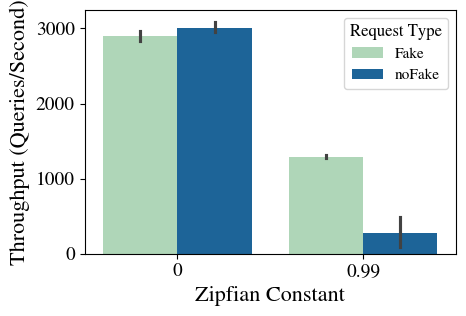

In [30]:
onlyWaffle = combined_df[combined_df['ScaleFactor']=="Waffle"]

onlyWaffle['Skew'] = onlyWaffle['Label'].apply(lambda label: '0.99' if 'Zipf0.99' in label else '0')
onlyWaffle


# Extract the fake/nofake information from Label column
onlyWaffle['FakeType'] = onlyWaffle['PercentFake'].apply(lambda x: 'Fake' if x>0 else 'noFake')


# Create the plot
fig, ax = plt.subplots(figsize=(5, 3.5))

# Define consistent colors for Fake and noFake
colors = {'Fake': '#a8ddb5', 'noFake': '#0868ac'}  # Blue for Fake, Orange for noFake

# Create the grouped bar plot
sns.barplot(data=onlyWaffle, x="Skew", y="Throughput", hue="FakeType", palette=colors, ax=ax)

# Customize the plot
ax.set_ylabel("Throughput (Queries/Second)", fontsize=16)
ax.set_xlabel("Zipfian Constant", fontsize=16)
# ax.set_title("Fake Request Overhead", fontsize=13)
ax.legend(title="Request Type", loc="upper right", fontsize=11, title_fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.show()



fig.savefig("/home/haseeb/Desktop/ReviewGraphs/Figures/FakeOverhead.png", format='png')